# Introduction
This colab worksheet provides a starting point for the computer vision assignment. 

# Data Loading

In [1]:
# Download the data stored in a zipped numpy array from one of these two locations
import numpy as np

# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

# Load the testing data using np.load
data = np.load('test_images.npz', allow_pickle=True)
test_images = data['images']

data = np.load('examples.npz', allow_pickle=True)
examples = data['images']

zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget


FileNotFoundError: [Errno 2] No such file or directory: 'training_images.npz'

In [98]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

  Using cached https://files.pythonhosted.org/packages/61/29/fc60b2de1713aa92946992544329f20ccb5e4ba26290f403e04b7da44105/opencv_contrib_python-3.4.2.17-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/03/27/e35e7c6e6a52fab9fcc64fc2b20c6b516eba930bb02b10ace3b38200d3ab/numpy-1.18.4-cp36-cp36m-manylinux1_x86_64.whl
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4
  Found existing installation: opencv-contrib-python 3.4.2.17
    Unins

# Data Visualisation
Here's an example of how to display the images and their points

(2811, 250, 250, 3) (2811, 68, 2)


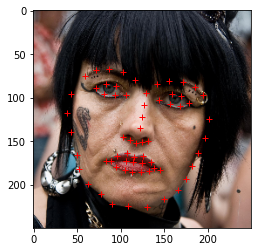

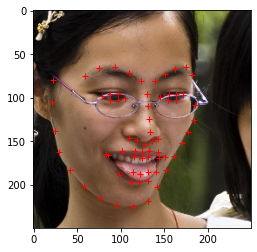

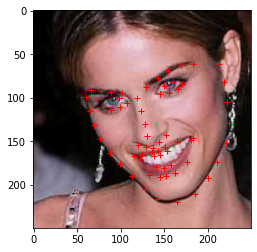

In [99]:
print(images.shape, pts.shape)
def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], pts[idx, ...])

# Calculating Prediction Error and exporting results

In [ ]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

In [ ]:
def save_as_csv(points, location = '.'):
  """
  Save the points out as a .csv file
  :param points: numpy array of shape (no_image, no_points, 2) to be saved
  :param location: Directory to save results.csv in. Default to current working directory
  """
  np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

# 1. Face Alignment

## Process

In [ ]:
# Importing the libraries used:
from sklearn.model_selection import train_test_split 
# Using Skicit-learn to split data into training and testing sets
from sklearn.linear_model import LinearRegression
# Using Skicit-learn to create a linear regressor model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# Using Skicit-learn to calcualte the mean absolute error and mean square error
from math import sqrt
# Used to calculate the square root
from statistics import mean
# Used to calculate the mean
import matplotlib.pyplot as plt
# Using matplotlib to display images
import cv2
# Importing open cv2 package
from skimage.feature import hog
# Using skimage to extract features from the images using hog
from skimage import exposure
# Using skimage to change intensity for the hog image
from sklearn import preprocessing
# Using Skicit-learn to preprocess data
from sklearn.decomposition import PCA
# Using Skicit-learn to implement PCA on data
from sklearn import neighbors
# Using Skicit-learn to implement the kNN regressor
from sklearn.preprocessing import MinMaxScaler
# Using Skicit-learn for standardising the data
from sklearn.ensemble import RandomForestRegressor 
# Using Skicit-learn to make a random forest regressor

In [ ]:
def evaluate(predictions, actual):
  """
  Evaluates the model by assessing the predicted points and actual points
  :param predictions: The predicted points of the testing images
  :param actual: The groud truth points of the testing images
  :return el: The euclidean distance
  """
  # Calculate the euclidean distance
  el = euclid_dist(predictions, actual) 
  print('Euclid distance mean: ', np.mean(el))

  # Calculating the mean absolute error
  mae = mean_absolute_error(actual, predictions)
  print('Mean absolute error: ', mae) 
  print('Mean absolute percentage error', (mae*100))

  # Calculating the mean squared error
  mse = mean_squared_error(actual, predictions)
  print('Mean squared error: ', mse) 
  print('Root mean squared error', sqrt(mse))
  return el


In [ ]:
def displayImageTP(prediction, actual, image):
  """
  Displays an image with the predicted and actual points on an image
  :param predictions: The predicted points of the image
  :param actual: The actual points of the image
  :param image: The image to be displayed, already reshaped
  """
  p = prediction.reshape((68,2)) # Reshape prediction points
  t = actual.reshape((68,2)) # Reshape actual points

  # Display the image
  plt.imshow(image)
  plt.plot(t[:, 0], t[:, 1], '+r')
  plt.plot(p[:, 0], p[:, 1], '+b')
  plt.title('Image with the actual landmarks(red) \nand predicted landmarks(blue)')
  plt.show()

In [ ]:
def plotCumulative(predictions, actuals):
  """
  Creates cumulative density graph of the mean absolute error for each point
  :param predictions: A list of prediction lists from different models
  :param actual: A list of actual test label lists from different models
  """
  for line in range(len(predictions)):
    error = sum(abs(actuals[line] - predictions[line] ))/len(actuals[line]) # finds the average error for each image
    plt.step(np.sort(error), np.linspace(0,1,len(error)))
  plt.xlabel('The average error for each test image; prediction vs actual')
  plt.ylabel('Cumulative Density')
  plt.title('The average error of each test image \n predictitions calculated by the model')
  plt.legend(('Original', 'Final'))
  plt.show()

### Linear Regressor

In this section, I will be creating a basic linear regressor from sklearn. I resize the images and points, then I split the data into training and testing features and labels, with a test size of 0.25. A linear regressor is then initialised and trained on the training features and labels. The regressor then predicts the points on the testing features. The euclid distance is then calculated for each point and the mean is found. 

In [106]:
numberOfImages = len(images) #Number of images used from the training images
def reshapeImages(images):
  """
  Reshapes the data so the regressor can fit
  :param images: The training images images 
  :return: the reshaped images
  """
  print('Images before = ', images.shape)
  image = images.reshape((len(images),-1))
  print('Images after = ', image.shape)
  return image

def reshapePts(points):
  """
  Reshapes the data so the regressor can fit
  :param points: The ground truth points of the training images
  :return: the reshaped points
  """
  print('Points before = ', points.shape)
  pt = points.reshape((len(points), -1))
  print('Points after = ', pt.shape)
  return pt

#Reshape the images and points - using only the first numberOfImages of training points
trainingImages = reshapeImages(images[:numberOfImages,:])
trainingPoints = reshapePts(pts[:numberOfImages,:])

# Split into training and testing features and labels (random_state -> allows reproducible data), split 0.75 training, 0.25 testing
train_features, test_features, train_labels, test_labels = train_test_split(trainingImages, trainingPoints, test_size = 0.25, random_state = 0)

# Train and fit the linear regressor
reg = LinearRegression()
reg.fit(train_features, train_labels)

Images before =  (2811, 250, 250, 3)
Images after =  (2811, 187500)
Points before =  (2811, 68, 2)
Points after =  (2811, 136)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [107]:
# Get the predictions of the test features
predictions = reg.predict(test_features)
linearError = evaluate(predictions, test_labels)
originalPre = predictions
originalTest = test_labels

Euclid distance mean:  8.698673705275073
Mean absolute error:  5.519980556208308
Mean absolute percentage error 551.9980556208308
Mean squared error:  58.71842497366536
Root mean squared error 7.662794853946265


### Feature Extraction Techniques

#### SIFT

In [ ]:
def returnSiftImages(image):
  """
  Executes SIFT on the image
  :param image: The image to extract features from
  :return keypoint_image: The original image with keypoints indicated
  """
  kp = sift.detect(image, None) # detects the keypoints on the image
  keypoint_image = np.zeros_like(image) # create a np array of zeros of the size of the image parameter
  cv2.drawKeypoints(image, kp, keypoint_image) # draws the keypoints found on the oriignal image and saves under keypoint_image
  return keypoint_image

# Initialising SIFT - using sift to detect keypoints
sift = cv2.xfeatures2d.SIFT_create()

#### SURF

In [ ]:
def returnSurfImages(image):
  """
  Executes SUFT on the image
  :param image: The image to extract features from
  :return keypoint_image: The original image with keypoints indicated using SURF
  """
  kp = surf.detect(image, None) # detects the keypoints of the image using SURF
  keypoint_image = np.zeros_like(image) # create a np array of zeros of the size of the image parameter
  cv2.drawKeypoints(image, kp, keypoint_image) # draws the keypoints found on the orignal image and saves under keypoint_image
  return keypoint_image

# Initialise SURF 
surf = cv2.xfeatures2d.SURF_create()

#### FAST

In [ ]:
def returnFastImages(image):
  """
  Executes FAST on the image
  :param image: The image to extract features from
  :return keypoint_image: The original image with keypoints indicated using FAST
  """
  kp = fast.detect(image, None) # Detects key points on the image 
  keypoint_image = np.zeros_like(image)# create a np array of zeros of the size of the image parameter
  cv2.drawKeypoints(image, kp, keypoint_image) # draws the keypoints found on the orignal image and saves under keypoint_image
  return keypoint_image

fast = cv2.FastFeatureDetector_create()

#### BRIEF

In [ ]:
def returnBriefImages(image):
  """
  Executes BRIEF on the image
  :param image: The image to extract features from
  :return keypoint_image: The original image with keypoints indicated using BRIEF
  """
  fkp = fast.detect(image, None) # detects keypoints on the images using fast
  kp, x = brief.compute(image, fkp) # uses the keypoints detected to run brief on the image 
  keypoint_image = np.zeros_like(image) # create a np array of zeros of the size of the image parameter
  cv2.drawKeypoints(image, kp, keypoint_image) # draws the keypoints found on the orignal image and saves under keypoint_image
  return keypoint_image

# Initialise cv methods
fast = cv2.FastFeatureDetector_create() 
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

#### ORB

In [ ]:
def returnOrbImages(image):
  """
  Executes ORB on the image
  :param image: The image to extract features from
  :return keypoint_image: The original image with keypoints indicated using ORB
  """
  kp = orb.detect(image, None) # detects the keypoints of the images using ORB
  keypoint_image = np.zeros_like(image) # create a np array of zeros of the size of the image parameter
  cv2.drawKeypoints(image, kp, keypoint_image) # draws the keypoints found on the orignal image and saves under keypoint_image
  return keypoint_image

# Initialise ORB
orb = cv2.ORB_create()

#### HOG

In [ ]:
def returnHogImages(image):
  """
  Executes HOG on the image
  :param image: The image to extract features from
  :return hog_image: The original image with keypoints indicated
  """
  fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=True)
  hog_image = exposure.rescale_intensity(hog_image, in_range=(0,10))
  return hog_image

#### Edge Detection

In [ ]:
def returnEdgeImages(image):
  """
  Executes Edge detection on the image
  :param image: The image to extract features from
  :return edges: The original image with edges detected
  """
  edges = cv2.Canny(image,100,200)
  return edges

#### Running Feature detectors

In [ ]:
numberOfImages = 200

In [ ]:
def processImages(images):
  """
  Completes methods used on training data before model is fitted/on testing data before data is predicted
  :param images: A array of images
  :return featureImages: The images that has had its features described
  """
  print('Images before = ', images.shape)
  featureImages = []
  for image in images[:numberOfImages]:
    newFeature = returnHogImages(image) # Change feature descriptor method
    featureImages.append(newFeature)
  featureImages = np.array(featureImages)
  print('Edge images shape = ', featureImages.shape)
  return featureImages

In [117]:
# Retrieve the images that have been processed and are ready to train the model
trainingImages = processImages(images[:numberOfImages,:])

#Reshape the images and points - using only the first numberOfImages of training points
trainingImages = reshapeImages(trainingImages)
trainingPoints = reshapePts(pts[:numberOfImages,:])

# Split into training and testing features and labels (random_state -> allows reproducible data), split 0.75 training, 0.25 testing
train_features, test_features, train_labels, test_labels = train_test_split(trainingImages, trainingPoints, test_size = 0.25, random_state = 0)

# Train and fit the linear regressor
reg = LinearRegression()
reg.fit(train_features, train_labels)

Images before =  (200, 250, 250, 3)
Edge images shape =  (200, 250, 250)
Images before =  (200, 250, 250)
Images after =  (200, 62500)
Points before =  (200, 68, 2)
Points after =  (200, 136)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [118]:
# Get the predictions of the test features
predictions = reg.predict(test_features)
hogError = evaluate(predictions, test_labels)

Euclid distance mean:  6.6363495332150055
Mean absolute error:  4.216793000251592
Mean absolute percentage error 421.67930002515914
Mean squared error:  35.83162735870859
Root mean squared error 5.985952502209535


### Pre-processing

In [ ]:
numberOfImages = 200 #Number of images used from the training images

In [120]:
def processImages(images):
  """
  Completes methods used on training data before model is fitted/on testing data before data is predicted
  :param images: A array of images
  :return featureImages: The images that has had its features described
  """
  print('Images before = ', images.shape)
  featureImages = []
  for image in images[:numberOfImages]:
    newFeature = returnHogImages(image) 
    featureImages.append(newFeature)
  featureImages = np.array(featureImages)
  print('Images after = ', featureImages.shape)
  return featureImages

# Retrieve the images that have been processed and are ready to train the model
trainingImages = processImages(images[:numberOfImages,:])

#Reshape the images and points - using only the first numberOfImages of training points
trainingImages = reshapeImages(trainingImages)
trainingPoints = reshapePts(pts[:numberOfImages,:])

# Split into training and testing features and labels (random_state -> allows reproducible data), split 0.75 training, 0.25 testing
train_features, test_features, train_labels, test_labels = train_test_split(trainingImages, trainingPoints, test_size = 0.25, random_state = 0)

# Normalise the features
x = test_features # Used when displaying the image

# Train and fit the linear regressor
reg = LinearRegression()
reg.fit(train_features, train_labels)

Images before =  (200, 250, 250, 3)
Images after =  (200, 250, 250)
Images before =  (200, 250, 250)
Images after =  (200, 62500)
Points before =  (200, 68, 2)
Points after =  (200, 136)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [121]:
# Get the predictions of the test features
predictions = reg.predict(test_features)
preError = evaluate(predictions, test_labels)

Euclid distance mean:  6.6363495332150055
Mean absolute error:  4.216793000251592
Mean absolute percentage error 421.67930002515914
Mean squared error:  35.83162735870859
Root mean squared error 5.985952502209535


#### Normalisation

In [ ]:
numberOfImages = 200 #Number of images used from the training images

In [ ]:
def normalise(train, test):
  """
  Normalising the training and testing features - scaling samples to have a unit norm
  :param train: Is the training features to be normalised
  :param test: Is the testing features to be normalised
  :return train: Is the new normalised training data
  :return test: Is the new normalised testing data
  """
  normalizer = preprocessing.Normalizer().fit(train) # Fits the normaliser to the training data
  train = normalizer.transform(train) # Transforms the training data
  test = normalizer.transform(test) # Transforms the testing data
  return train, test

In [124]:
# Retrieve the images that have been processed and are ready to train the model
trainingImages = processImages(images[:numberOfImages,:])

#Reshape the images and points - using only the first numberOfImages of training points
trainingImages = reshapeImages(images[:numberOfImages,:])
trainingPoints = reshapePts(pts[:numberOfImages,:])

# Split into training and testing features and labels (random_state -> allows reproducible data), split 0.75 training, 0.25 testing
train_features, test_features, train_labels, test_labels = train_test_split(trainingImages, trainingPoints, test_size = 0.25, random_state = 0)

# Normalise the features
x = test_features # Used when displaying the image
train_features, test_features = normalise(train_features, test_features)

# Train and fit the linear regressor
reg = LinearRegression()
reg.fit(train_features, train_labels)

Images before =  (200, 250, 250, 3)
Images after =  (200, 250, 250)
Images before =  (200, 250, 250, 3)
Images after =  (200, 187500)
Points before =  (200, 68, 2)
Points after =  (200, 136)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [125]:
# Get the predictions of the test features
predictions = reg.predict(test_features)
normError = evaluate(predictions, test_labels)

Euclid distance mean:  10.008125662976157
Mean absolute error:  6.299607507169877
Mean absolute percentage error 629.9607507169877
Mean squared error:  75.52803141915354
Root mean squared error 8.690686475713731


#### PCA

In [ ]:
def pca(train, test):
  """
  This method reduces the dimentionality of the data and filters noise
  :param train: Training data to undergo PCA
  :param test: Testing data to undergo PCA
  :return train: Reduced training data
  :return test: Reduced testing data
  """
  pca = PCA(.85) # PCA initialised with 95% of the components kepts
  pca.fit(train) # Train on the training data
  train = pca.transform(train) # Transform the training data
  test = pca.transform(test) # Transform the testing data
  return train, test

In [127]:
# Retrieve the images that have been processed and are ready to train the model
trainingImages = processImages(images[:numberOfImages,:])

#Reshape the images and points - using only the first numberOfImages of training points
trainingImages = reshapeImages(images[:numberOfImages,:])
trainingPoints = reshapePts(pts[:numberOfImages,:])

# Split into training and testing features and labels (random_state -> allows reproducible data), split 0.75 training, 0.25 testing
train_features, test_features, train_labels, test_labels = train_test_split(trainingImages, trainingPoints, test_size = 0.25, random_state = 0)


Images before =  (200, 250, 250, 3)
Images after =  (200, 250, 250)
Images before =  (200, 250, 250, 3)
Images after =  (200, 187500)
Points before =  (200, 68, 2)
Points after =  (200, 136)


In [128]:
# Normalise then PCA the features
x = test_features # Used when displaying the image
train_features, test_features = normalise(train_features, test_features)
train_features, test_features = pca(train_features, test_features)

# Train and fit the linear regressor
reg = LinearRegression()
reg.fit(train_features, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [129]:
# Get the predictions of the test features
predictions = reg.predict(test_features)
normPcaError = evaluate(predictions, test_labels)

Euclid distance mean:  9.246775928352356
Mean absolute error:  5.839142070092364
Mean absolute percentage error 583.9142070092364
Mean squared error:  63.82094647083481
Root mean squared error 7.9888013162698455


#### Filters

##### Laplacian

In [ ]:
def filterLap(img):
  """
  Filter the image with laplacian filter
  :param img: The image to apply a filter too
  :return lap: the image with the laplacian filter
  """
  lap = cv2.Laplacian(img, cv2.CV_64F)
  return lap

##### Bilateral

In [ ]:
def filterBil(img):
  """
  Filter the image with Bilateral filter
  :param img: The image to apply a filter too
  :return bil: the image with the bilateral filter
  """
  bil = cv2.bilateralFilter(img,9,img.std(),img.std())
  return bil

##### Median Blur

In [ ]:
def filterMed(img):
  """
  Filter the image with Median filter
  :param img: The image to apply a filter too
  :return med: the image with the median filter
  """
  med = cv2.medianBlur(img,5)
  return med

##### Gaussian Blur

In [ ]:
def filterGau(img):
  """
  Filter the image with gaussian filter
  :param img: The image to apply a filter too
  :return gau: the image with the gaussian filter
  """
  gau = cv2.GaussianBlur(img,(5,5),0)
  return gau

##### Convolution

In [ ]:
def filterCon(img):
  """
  Filter the image with convolutional filter
  :param img: The image to apply a filter too
  :return con: the image with the convolutional filter
  """
  kernel = np.ones((5,5),np.float32)/25
  con = cv2.filter2D(img,-1,kernel)
  return con 

#### Running the filters

In [ ]:
numberOfImages = 200 #Number of images used from the training images

In [ ]:
original = 250
factor = 0.8

In [ ]:
def resizeImage(image, factor=0.8):
  """
  Resizes an image
  :param image: The image to be resized
  "param factor: The factor to which the image is resized
  :return img: The resized image
  """
  img = cv2.resize(np.array(image), (int(image.shape[0]*factor),int(image.shape[1]*factor)))
  return img

In [ ]:
def resizePts(pts, factor=0.8):
  """
  Resizes the points
  :param pts: An array of points that point to an images landmark points
  :param factor: The factor to which the points are scaled, same as the images
  :return newPoints: An array of the resized points
  """
  newPoints = pts.copy()
  for i, point in enumerate(pts):
    newPoints[i][:,0] = point[:,0] * factor
    newPoints[i][:,1] = point[:,1] * factor
  return np.array(newPoints)

In [ ]:
def preprocess(image):
  """
  Pre-processes the image
  :param image: The image to be preprocessed
  :return img: The processed image
  """
  img = filterGau(image) # Change filter 
  img = np.uint8(np.mean(img, axis=-1)) # Turns image into gray scale image
  img = resizeImage(img)
  return img

In [ ]:
def processImages(images):
  """
  Completes methods used on training data before model is fitted/on testing data before data is predicted
  :param images: A array of images
  :return processedImages: The images that has been preprocessed
  """
  print('Images before = ', images.shape)
  processedImages = []
  for image in images:
    pre = preprocess(image)
    newHog = returnHogImages(pre)
    processedImages.append(newHog)
  processedImages = np.array(processedImages)
  print('Processed images shape = ', processedImages.shape)
  return processedImages

In [144]:
# Retrieve the images that have been processed and are ready to train the model
trainingImages = processImages(images[:numberOfImages,:])

#Reshape the images - using only the first numberOfImages of training points
trainingImages = reshapeImages(trainingImages)

# Reshape and resize the points
trainingPoints = resizePts(pts[:numberOfImages,:])
trainingPoints = reshapePts(trainingPoints)

# Split into training and testing features and labels (random_state -> allows reproducible data), split 0.75 training, 0.25 testing
train_features, test_features, train_labels, test_labels = train_test_split(trainingImages, trainingPoints, test_size = 0.25, random_state = 0)

# Normalise then PCA the features
x = test_features # Used when displaying the image
train_features, test_features = standardise(train_features, test_features)
train_features, test_features = pca(train_features, test_features)

# Train and fit the linear regressor
reg = LinearRegression()
reg.fit(train_features, train_labels)

Images before =  (200, 250, 250, 3)
Processed images shape =  (200, 200, 200)
Images before =  (200, 200, 200)
Images after =  (200, 40000)
Points before =  (200, 68, 2)
Points after =  (200, 136)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [145]:
# Get the predictions of the test features
predictions = reg.predict(test_features)
conError = evaluate(predictions, test_labels)

Euclid distance mean:  5.262746396680039
Mean absolute error:  3.3516579991216853
Mean absolute percentage error 335.16579991216855
Mean squared error:  22.085992144490614
Root mean squared error 4.699573613051573


### Other Regression Methods

#### Preprocessing for regressors

In [ ]:
numberOfImages = 200 #Number of images used from the training images
original = 250 # the original number of pixels
factor = 0.8 # the factor to what the images and points are resized to

In [ ]:
def resizeImage(image, factor=0.8):
  """
  Resizes an image
  :param image: The image to be resized
  "param factor: The factor to which the image is resized
  :return img: The resized image
  """
  img = cv2.resize(np.array(image), (int(image.shape[0]*factor),int(image.shape[1]*factor)))
  return img

In [ ]:
def resizePts(pts, factor=0.8):
  """
  Resizes the points
  :param pts: An array of points that point to an images landmark points
  :param factor: The factor to which the points are scaled, same as the images
  :return newPoints: An array of the resized points
  """
  newPoints = pts.copy()
  for i, point in enumerate(pts):
    newPoints[i][:,0] = point[:,0] * factor
    newPoints[i][:,1] = point[:,1] * factor
  return np.array(newPoints)

In [ ]:
def filterGau(img):
  """
  Filter the image with gaussian filter
  :param img: The image to apply a filter too
  :return gau: the image with the gaussian filter
  """
  gau = cv2.GaussianBlur(img,(5,5),0)
  return gau

In [ ]:
def preprocess(image):
  """
  Pre-processes the image
  :param image: The image to be preprocessed
  :return img: The processed image
  """
  img = filterGau(image)
  img = np.uint8(np.mean(img, axis=-1)) # Turns image into gray scale image
  img = resizeImage(img)
  return img

In [ ]:
def returnHogImages(image):
  """
  Executes HOG on the image
  :param image: The image to extract features from
  :return hog_image: The original image with keypoints indicated
  """
  fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=True)
  hog_image = exposure.rescale_intensity(hog_image, in_range=(0,10))
  return hog_image

In [ ]:
def processImages(images):
  """
  Completes methods used on training data before model is fitted/on testing data before data is predicted
  :param images: A array of images
  :return processedImages: The images that has been preprocessed
  """
  print('Images before = ', images.shape)
  processedImages = []
  for image in images:
    pre = preprocess(image)
    newHog = returnHogImages(pre)
    processedImages.append(newHog)
  processedImages = np.array(processedImages)
  print('Processed images shape = ', processedImages.shape)
  return processedImages

In [153]:
# Retrieve the images that have been processed and are ready to train the model
trainingImages = processImages(images[:numberOfImages,:])

#Reshape the images - using only the first numberOfImages of training points
trainingImages = reshapeImages(trainingImages)

# Reshape and resize the points
trainingPoints = resizePts(pts[:numberOfImages,:])
trainingPoints = reshapePts(trainingPoints)

# Split into training and testing features and labels (random_state -> allows reproducible data), split 0.75 training, 0.25 testing
train_features, test_features, train_labels, test_labels = train_test_split(trainingImages, trainingPoints, test_size = 0.25, random_state = 0)

# Normalise then PCA the features
x = test_features # Used when displaying the image
train_features, test_features = normalise(train_features, test_features)
train_features, test_features = pca(train_features, test_features)

Images before =  (200, 250, 250, 3)
Processed images shape =  (200, 200, 200)
Images before =  (200, 200, 200)
Images after =  (200, 40000)
Points before =  (200, 68, 2)
Points after =  (200, 136)


#### Linear Regressor

In [154]:
# Train and fit the linear regressor
reg = LinearRegression()
reg.fit(train_features, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [155]:
# Get the predictions of the test features
lPredictions = reg.predict(test_features)
linearError = evaluate(lPredictions, test_labels)

Euclid distance mean:  5.030862182902498
Mean absolute error:  3.2147023598390216
Mean absolute percentage error 321.47023598390217
Mean squared error:  19.68752466925872
Root mean squared error 4.43706261723437


#### K-Nearest Neighbour Regressor

In [156]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(train_features, train_labels)  #fit the model

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [157]:
# Get the predictions of the test features
knnPredictions = knn.predict(test_features)
knnError = evaluate(knnPredictions, test_labels)

Euclid distance mean:  6.807903204601877
Mean absolute error:  4.331685964328714
Mean absolute percentage error 433.1685964328714
Mean squared error:  35.42516981514266
Root mean squared error 5.9519047216116165


#### Random Forest Regression

In [158]:
# Train and fit the regressor
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [159]:
# Get the predictions of the test features
rfPredictions = rf.predict(test_features)
rfError = evaluate(rfPredictions, test_labels)

Euclid distance mean:  6.510168535870769
Mean absolute error:  4.1485004331302076
Mean absolute percentage error 414.85004331302076
Mean squared error:  32.839715496456726
Root mean squared error 5.730594689598692


#### Voting System

In [ ]:
votedPre = []
for i in range(len(lPredictions)):
  ave = np.mean([lPredictions[i], rfPredictions[i], knnPredictions[i]], axis=0)
  votedPre.append(ave)
votedPre = np.array(votedPre)

In [161]:
votingError = evaluate(votedPre, test_labels)

Euclid distance mean:  5.7367359366277295
Mean absolute error:  3.6587922843590133
Mean absolute percentage error 365.8792284359013
Mean squared error:  25.856815953121814
Root mean squared error 5.084959778908956


## Final Face Alignment Algorithm

In [ ]:
numberOfImages = len(images) #Number of images used from the training images
original = 250 # the original number of pixels
factor = 0.8 # the factor to what the images and points are resized to

In [ ]:
def resizeImage(image, factor=0.8):
  """
  Resizes an image
  :param image: The image to be resized
  "param factor: The factor to which the image is resized
  :return img: The resized image
  """
  img = cv2.resize(np.array(image), (int(image.shape[0]*factor),int(image.shape[1]*factor)))
  return img

In [ ]:
def resizePts(pts, factor=0.8):
  """
  Resizes the points
  :param pts: An array of points that point to an images landmark points
  :param factor: The factor to which the points are scaled, same as the images
  :return newPoints: An array of the resized points
  """
  newPoints = pts.copy()
  for i, point in enumerate(pts):
    newPoints[i][:,0] = point[:,0] * factor
    newPoints[i][:,1] = point[:,1] * factor
  return np.array(newPoints)

In [ ]:
def filterGau(img):
  """
  Filter the image with gaussian filter
  :param img: The image to apply a filter too
  :return gau: the image with the gaussian filter
  """
  gau = cv2.GaussianBlur(img,(5,5),0)
  return gau

In [ ]:
def preprocess(image):
  """
  Pre-processes the image
  :param image: The image to be preprocessed
  :return img: The processed image
  """
  img = filterGau(image) # Put a bilateral filter on the image
  img = np.uint8(np.mean(img, axis=-1)) # Turns image into gray scale image
  img = resizeImage(img) # Lowers the resolution of the image
  return img

In [ ]:
def returnHogImages(image):
  """
  Executes HOG on the image
  :param image: The image to extract features from
  :return hog_image: The original image with keypoints indicated
  """
  fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=True)
  hog_image = exposure.rescale_intensity(hog_image, in_range=(0,10))
  return hog_image

In [ ]:
def processImages(images):
  """
  Completes methods used on training data before model is fitted/on testing data before data is predicted
  :param images: A array of images
  :return processedImages: The images that has been preprocessed
  """
  print('Images before = ', images.shape)
  processedImages = []
  for image in images:
    pre = preprocess(image) # Preprocess the image
    newHog = returnHogImages(pre) # Use HOG to extract the features
    processedImages.append(newHog)
  processedImages = np.array(processedImages)
  print('Processed images shape = ', processedImages.shape)
  return processedImages

In [ ]:
def reshapeImages(images):
  """
  Reshapes the data so the regressor can fit
  :param images: The training images images 
  :return: the reshaped images
  """
  #Resizes the images 
  image = images.reshape((len(images),-1))
  return image

def reshapePts(points):
  """
  Reshapes the data so the regressor can fit
  :param points: The ground truth points of the training images
  :return: the reshaped points
  """
  #Resizes the pts 
  pt = points.reshape((len(points), -1))
  return pt

In [ ]:
def normalise(train, test):
  """
  Normalising the training and testing features - scaling samples to have a unit norm
  :param train: Is the training features to be normalised
  :param test: Is the testing features to be normalised
  :return train: Is the new normalised training data
  :return test: Is the new normalised testing data
  """
  normalizer = preprocessing.Normalizer().fit(train) # Fits the normaliser to the training data
  train = normalizer.transform(train) # Transforms the training data
  test = normalizer.transform(test) # Transforms the testing data
  return train, test, normalizer

In [ ]:
def pca(train, test):
  """
  This method reduces the dimentionality of the data and filters noise
  :param train: Training data to undergo PCA
  :param test: Testing data to undergo PCA
  :return train: Reduced training data
  :return test: Reduced testing data
  """
  pca = PCA(.85) # PCA initialised with 95% of the components kept
  pca.fit(train) # Train on the training data
  train = pca.transform(train) # Transform the training data
  test = pca.transform(test) # Transform the testing data

  return train, test, pca

In [172]:
# Retrieve the images that have been processed and are ready to train the model
trainingImages = processImages(images[:numberOfImages,:])

#Reshape the images - using only the first numberOfImages of training points
trainingImages = reshapeImages(trainingImages)

# Reshape and resize the points
trainingPoints = resizePts(pts[:numberOfImages,:])
trainingPoints = reshapePts(trainingPoints)

# Split into training and testing features and labels (random_state -> allows reproducible data), split 0.75 training, 0.25 testing
train_features, test_features, train_labels, test_labels = train_test_split(trainingImages, trainingPoints, test_size = 0.25, random_state = 0)

# Normalise then PCA the features
x = test_features # Used when displaying the image
train_features, test_features, normaliser = normalise(train_features, test_features)
train_features, test_features, pca = pca(train_features, test_features)

Images before =  (2811, 250, 250, 3)
Processed images shape =  (2811, 200, 200)


In [173]:
# Train and fit the linear regressor
reg = LinearRegression()
reg.fit(train_features, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [182]:
# Get the predictions of the test features
predictions = reg.predict(test_features)
elError = evaluate(predictions, test_labels)

Euclid distance mean:  4.416083695345078
Mean absolute error:  2.804048263090304
Mean absolute percentage error 280.4048263090304
Mean squared error:  15.68382626491815
Root mean squared error 3.9602810840795315


### Retrieve Points

In [ ]:
def revertPts(points, factor=0.8):
  """
  Resizes the points back to the 250x250 pixels
  :param pts: An array of points that point to an images landmark points
  :param factor: The factor to which the points are scaled, same as the original images
  :return newPoints: An array of the 250x250 points
  """
  newPoints = points.copy()
  for i, point in enumerate(points):
    newPoints[i][:,0] = point[:,0] / factor
    newPoints[i][:,1] = point[:,1] / factor
  return np.array(newPoints)

In [ ]:
def getPoints(images, normaliser, pca, reg):
  """
  Pre-processes the images, the same way the training data is processed, then the points are predicted
  :param image: The image that the points are predicted for
  :param normaliser: The normaliser that was fitted to the training data
  :param pca: The PCA method that was fitted to the training data
  :param reg: The regressor that was trained using the training data
  :return predictions: The prediction points of the image
  """
  #Process the image
  preprocessed = processImages(images) # Preprocessed the image
  reshaped = reshapeImages(preprocessed) # Reshapes the image
  normalised= normaliser.transform(reshaped) # Normalise the image
  pcaImages = pca.transform(normalised) # Preform PCA on the image

  #Predict the points
  predictions = reg.predict(pcaImages) # Predict the face landmark points of the image
  reshapePre = predictions.reshape([len(images),68,2]) # Return the reshaped prediction points
  finalPredictions = revertPts(reshapePre) # Resize the points so they fit the original 250x250 images
  return finalPredictions

# 2. Face Segmentation

In [ ]:
# Is a dictionary with the face landmarks and the number reference to the locations 
faceLandMarks = {'jaw':(0,17), 'left_eyebrow': (17,22), 'right_eyebrow':(22,27),
                 'nose': (27,36), 'left_eye':(36,42),'right_eye':(42,48), 'mouth':(48,68)}
  
def visualize_facial_landmarks(image, points):
  """
  Turn the image into an image with facial segmentation using the landmark points
  :param image: The image to perform the face segmentation on
  :param points: The landmark x,y points of the images landmarks
  :return segImage: The face segmentation image
  """
  segImage = image.copy() # Copys the image array to be changed
  # A list of colours used in the segmentation
  colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23), (168, 100, 168), (158, 163, 32), (163, 38, 32), (180, 42, 220)]
  for (i, name) in enumerate(faceLandMarks.keys()):
    (j, k) = faceLandMarks[name]
    # Gets the faceland mark numbers, for example jaw corresponds to points 0-17
    if name == "jaw": # If it relates to the jaw, then a line is drawn between points
      pts = points[j:k] # becomes a list of coordinates of the landmark points
      for j in range(1, len(pts)):
        a = tuple(pts[j - 1]) # a becomes the coordinates of the first feature
        a = (int(a[0]), int(a[1]))
        b = tuple(pts[j]) # becomes the coordinates of the next feature to join  
        b = (int(b[0]), int(b[1]))
        cv2.line(segImage, a, b, colors[i], 2) # draws the line with color[i], onto segImage, with thickness =2
    else:
      if name == "nose":
        pts = []
        pt = [27,31,32,33,34,35,27]
        for p in pt:
          pts.append([points[p]])
        pts = np.array(pts)
      else:
        pts = points[j:k] # becomes a list of coordinates of the landmark points
      cv2.fillPoly(segImage, np.int32([pts]), colors[i]) # Is the points for the polygon to be filled, with color[i]
  return segImage 

# 3. Graphical Effects

In [ ]:
def darken(first, last, points):
  """
  Return list of coordinates to be darkened
  :param first: The first landmark of the shape to be filled
  :param last: The last landmark of the shape to be filled
  :param points: Points on an image
  :return new: Array of coordinates of the first to the last landmark
  """
  pts = points[first:last]
  new = []
  for j in range(0, len(pts)): # For each point in the first to last landmark
    x = pts[j][0]
    y = pts[j][1]
    new.append([x, y]) # Add the x and y coordinate of the landmark
  new = np.array(new)
  return new

def graphicEffects(image, points):
  """
  Turn the eyes and mouth into black polygons
  :param image: The image to perform the graphical effect on
  :param points: The landmark points on the image
  :return darkened: The graphical effect image
  """
  darkened = image.copy() # a copy of the image which will eventually have a graphical effect

  leftEye = darken(42, 48, points) # get the coordinates between landmark 42 to 48
  rightEye = darken(36, 42, points) # get the coordinates between landmark 36 to 42
  mouth = darken(60, 68, points) # get the coordinates between landmark 60 to 68

  cv2.fillPoly(darkened, np.int32([leftEye]), (0,0,0)) # fill in the left eye polygon
  cv2.fillPoly(darkened, np.int32([rightEye]), (0,0,0)) # fill in the right eye polygon
  cv2.fillPoly(darkened, np.int32([mouth]), (0,0,0)) # fill in the mouth polygon
  return darkened